# 音频分词教程

**简明总结（TL;DR）**

为了将我们关于 [音频分词](audio_tokenization.md) 的知识付诸实践，我们将使用向量量化（VQ）技术将音频表示为一种紧凑且离散的形式。

我们将：
- 将音频转换为频谱图；
- 使用 K-Means 进行 VQ 聚类，对频谱图中相似的部分进行分组；
- 分析由 VQ 生成的 token；
- 从这些 token 中重建音频。

---

## 你需要了解的内容

由于本教程涉及音频分词的实际实现，你应该已经熟悉以下内容：

- [音频分词](audio_tokenization.md)
- [为什么它有用](audio_tokenization:importance)
- [向量量化（VQ）](audio_tokenization:acoustic_tokens:neural_compression)

此外，你还需要具备以下技能基础：

- 如何在 Python 中处理音频数据；
- 如何可视化音频信号并生成频谱图；
- 理解可以从音频信号中提取的各种特征及其提取方法。

如果你对上述概念不熟悉，我们已在 [《音频特征提取教程》](audio_feature_extraction.ipynb) 中详细介绍了相关内容。建议你在学习本教程之前先阅读该教程。

---

通过本教程的学习，你将获得对音频分词方法的深入理解，并了解其潜在的应用场景。我们将使用 VQ 对相似的音频特征进行聚类，并用单个 token 表示它们。这有助于我们构建一个有限的“词汇表”，就像我们在语言中使用有限的词汇来表达广泛的思想一样。

现在，让我们开始设置环境并进入代码部分吧！

## 环境配置

在深入音频分词的精彩世界之前，我们需要先配置好开发环境。本节将引导你完成导入必要的库并准备工作空间的过程。

### 所需库

为了完成本教程，我们将使用一些对音频处理和机器学习至关重要的 Python 库。现在我们来导入它们：

In [1]:
import numpy as np
import librosa 
import soundfile as sf
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import IPython.display as ipd

我们来逐一解释为什么需要这些库：

- **numpy (np)**：这是我们进行数值计算的首选库。我们将使用它来处理数组和执行各种计算。

- **librosa**：这是一个专为音乐和音频分析设计的强大库。我们将用它来加载音频文件、计算频谱图以及进行音频信号处理。

- **soundfile (sf)**：这个库允许我们读取和写入音频文件。我们将用它来保存重建后的音频。

- **sklearn.cluster.KMeans**：这是我们要用于向量量化（VQ）的 K-Means 聚类算法的实现。

- **matplotlib.pyplot (plt)**：这是我们用于绘图的库。我们将用它来可视化音频信号、频谱图和分词表示。

- **IPython.display (ipd)**：这将允许我们在 Jupyter Notebook 中直接播放音频。

## 加载音频并生成频谱图

现在我们已经配置好了环境，接下来首先加载一个音频文件，并将其转换为梅尔频谱图（Mel spectrogram）。我们将使用这个梅尔频谱图作为向量量化模型的输入。

首先，我们需要定义一个用于加载和预处理音频的函数。

In [2]:
def load_and_preprocess_audio(file_path, sr=None, n_mels=80):
    y, sr = librosa.load(file_path, sr=sr)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    log_mel_spec = librosa.power_to_db(mel_spec)
    return y, sr, log_mel_spec

让我们看看里面是什么东西

- 该函数接受文件路径、目标采样率（sr）和梅尔频带数量（n_mels）作为输入。  
- 它使用 librosa 加载音频文件，并在需要时进行重采样。  
- 接着，它计算出一个梅尔频谱图，这是一种模仿人耳对声音频率感知方式的音频表示形式。  
- 最后，它将频谱图转换为对数尺度，以更准确地反映我们对音量的感知。

In [5]:
audio_file = librosa.example('trumpet') # Here I'm using a sample audio file from librosa
# audio_file = "path_to_your_audio_file.wav"  # Replace with your audio file path

y, sampling_rate, mel_features  = load_and_preprocess_audio(audio_file)

print(f"Mel spectrogram shape: {mel_features.shape}")
print(f"Sampling rate: {sampling_rate}")
print(f"Original audio length: {y.shape[0]} samples")

ipd.Audio(y, rate=sampling_rate)

Mel spectrogram shape: (80, 230)
Sampling rate: 22050
Original audio length: 117601 samples


现在，我们把一段5s的音频，使用梅尔频谱，提取出了80个（tokens）230维度（hidden size）的特征

In [13]:
mel_features.max(), mel_features.min(), mel_features.mean(), mel_features.std(), mel_features.var(), mel_features.shape

(np.float32(22.63048),
 np.float32(-57.369522),
 np.float32(-38.89011),
 np.float32(21.713545),
 np.float32(471.478),
 (80, 230))

We can visualize the waveform first.

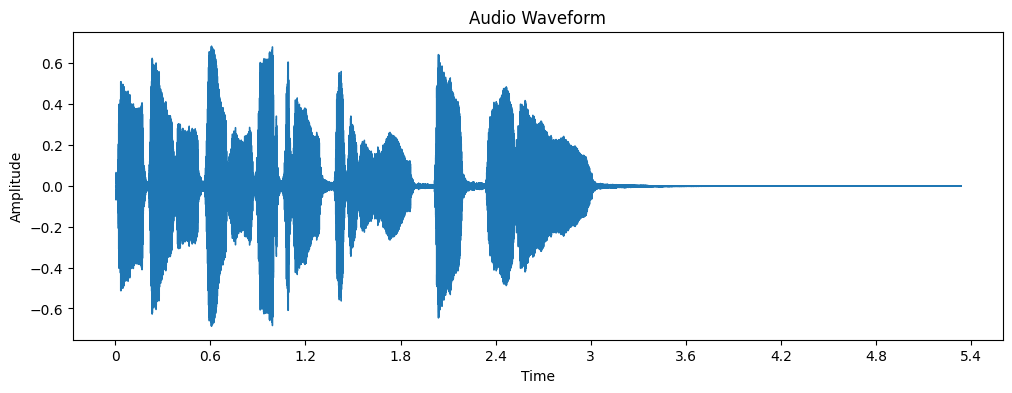

In [6]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sampling_rate)
plt.title('Audio Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


### 可视化频谱图

现在，让我们来看一看我们计算得到的梅尔频谱图。

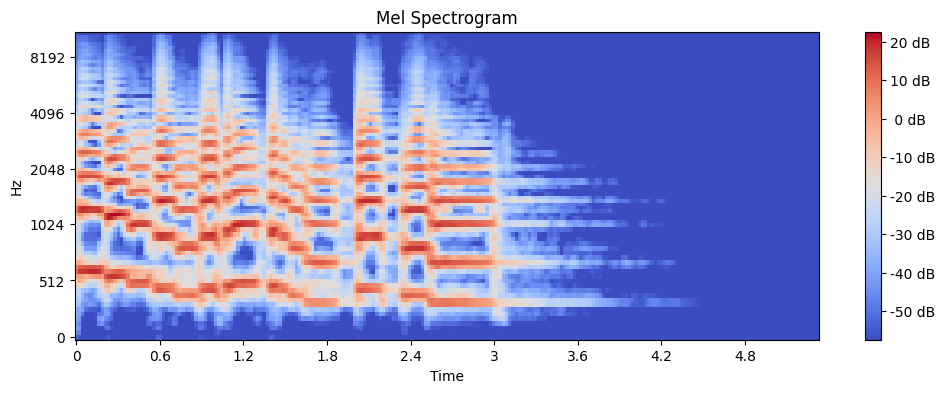

In [7]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(mel_features, sr=sampling_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%2.0f dB')
plt.title('Mel Spectrogram')
plt.show()

这张色彩丰富的图展示了不同频率随时间变化的强度。x 轴表示时间，y 轴表示梅尔频率带，颜色的深浅则代表了每个时间-频率点上的音量大小。

### 为什么使用梅尔频谱图（Mel Spectrograms）？
你可能会好奇，我们为什么要使用梅尔频谱图，而不是原始波形。其实有几个很好的理由：

- **梅尔频谱图是更紧凑的音频表示方式**：它能以更少的数据量捕捉音频的关键特征。
- **它强调人类对声音更敏感的频率范围**：这使得梅尔频谱图在模拟人耳听觉感知方面更加有效。
- **许多音频处理任务（如语音识别）在使用频谱图时表现更好**：相比于直接使用原始波形，频谱图通常能提供更丰富的声学信息。
- 在下一节中，我们将使用这个梅尔频谱图作为向量量化过程的输入：这意味着我们离将音频转换为 token 又近了一步！

(audio_tokenization_tutorial:vq_tokenization)=

向量量化（VQ）分词
现在我们已经将音频转换为梅尔频谱图的形式，接下来我们将进入整个流程的核心部分：使用向量量化（Vector Quantization, VQ）进行分词。这是将连续的音频表示转化为离散符号表示的关键步骤。

理解向量量化
在深入代码之前，让我们先花点时间来真正理解什么是向量量化，以及它为何如此强大。

向量量化是一种来自信号处理的经典技术，它允许我们将大量数据点压缩为一组更小的代表性点。

为了帮助理解，我们用一个类比来解释：

![image.png](https://ravinkumar.com/GenAiGuidebook/_images/crayons.png)

想象你有一个装有成千上万种略微不同颜色的蜡笔的大盒子。向量量化就像是从这些颜色中挑选出一组较小的蜡笔（比如 512 种），它们可以最好地代表原始颜色集合中的所有颜色。对于原始集合中的任意一种颜色，我们都会用这组较小颜色中最接近的颜色来表示它。

在我们的音频语境中：

- 原始的蜡笔代表梅尔频谱图中所有可能的声音片段。
- 我们选择的小蜡笔集合就是我们的“码本”或“token 词汇表”。
- 将原始颜色匹配到较小集合的过程，就是我们的分词过程。

## 实现 VQ 分词
接下来，我们详细看一下我们的 VQ 分词函数实现：


In [8]:
def vq_tokenize(features, n_tokens=512):
    # Flatten the 2D features to 1D
    flattened_features = features.T.flatten()
    
    # Reshape to 2D array (required input shape for KMeans)
    reshaped_features = flattened_features.reshape(-1, 1)
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_tokens, random_state=42)
    kmeans.fit(reshaped_features)
    
    # Get cluster assignments (tokens)
    tokens = kmeans.predict(reshaped_features)
    
    # Reshape tokens back to original shape (time, frequency)
    tokens = tokens.reshape(features.shape[1], -1)
    
    return tokens, kmeans


我们来逐步分解这个过程：

- 展平（Flattening）：首先，我们将 2D 的梅尔频谱图展平为一个 1D 数组。这是因为 K-means 算法处理的是 1D 向量。

- 重塑（Reshaping）：接着，我们将展平后的数组重新塑造成一个 2D 数组，其中每一行代表一个数据点。这是 scikit-learn 中 KMeans 函数所需的输入格式。

- K-means 聚类（K-means Clustering）：这是向量量化实际发生的地方。K-means 是一种算法，它尝试将我们的数据点划分为 n_tokens 个聚类。每个聚类由其质心（centroid）表示，这些质心就构成了我们的 token 词汇表。

- Token 分配（Token Assignment）：一旦 K-means 找到所有聚类，我们就可以用它来预测每个原始数据点属于哪个聚类。这种将数据点分配到不同聚类的过程就是我们的分词（tokenization）操作。

- 重塑回原结构（Reshaping）：最后，我们将得到的 tokens 重新恢复成与原始梅尔频谱图相同的形状。这使我们能够保留音频的时间-频率结构。

现在，让我们把这个流程应用到我们的梅尔频谱图上：

In [9]:
n_tokens = 64  # This is our vocabulary size
tokens, kmeans_model = vq_tokenize(mel_features, n_tokens)

print(f"Shape of tokens: {tokens.shape}")
print(f"Number of unique tokens: {len(np.unique(tokens))}")

Shape of tokens: (230, 80)
Number of unique tokens: 64


In [14]:
flattened_features = mel_features.T.flatten()
flattened_features.shape

(18400,)

In [15]:
# Reshape to 2D array (required input shape for KMeans)
reshaped_features = flattened_features.reshape(-1, 1)
reshaped_features.shape

(18400, 1)

In [16]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=n_tokens, random_state=42)
kmeans.fit(reshaped_features)

KMeans(n_clusters=64, random_state=42)

In [17]:
# Get cluster assignments (tokens)
tokens = kmeans.predict(reshaped_features)
tokens.shape

(18400,)

In [23]:
# Reshape tokens back to original shape (time, frequency)
tokens = tokens.reshape(mel_features.shape[1], -1)
tokens.max(), tokens.min(), tokens.mean(), tokens.std(), tokens.var(), tokens.shape

(np.int32(63),
 np.int32(0),
 np.float64(21.1625),
 np.float64(17.626521095324314),
 np.float64(310.69424592391306),
 (230, 80))

## 可视化分词表示
可视化可以帮助我们更好地理解分词后的音频。让我们创建一个颜色编码的可视化图：

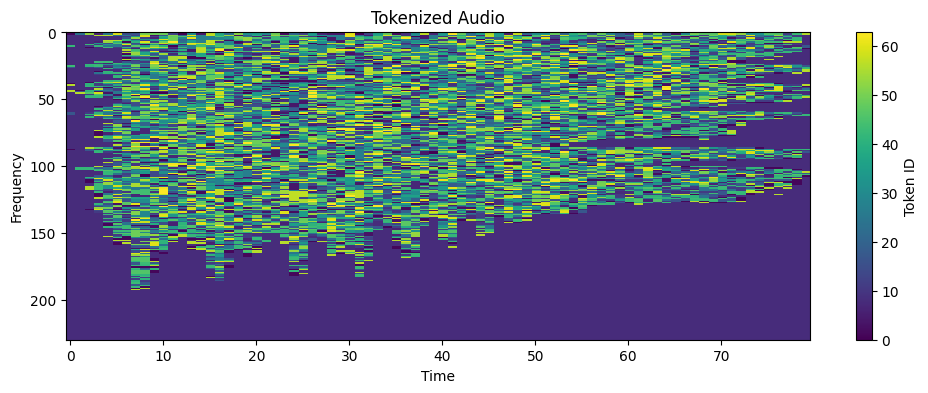

In [233]:
plt.figure(figsize=(12, 4))
plt.imshow(tokens, aspect='auto', interpolation='nearest', cmap='viridis')
plt.colorbar(label='Token ID')
plt.title('Tokenized Audio')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

在这张图中：

- x 轴 表示时间；
- y 轴 表示频率带；
- 每种颜色 代表一个不同的 token。

你可能会注意到可视化中的一些模式：

- 垂直条纹 通常表示持续的声音；
- 快速的颜色变化 可能表示瞬态声音或打击乐元素；
- 大块单一颜色区域 可能表示静音或背景噪声。

## 分析Token分布
了解我们的Token是如何被使用的，可以帮助我们深入了解音频质量和tokenization的有效性：


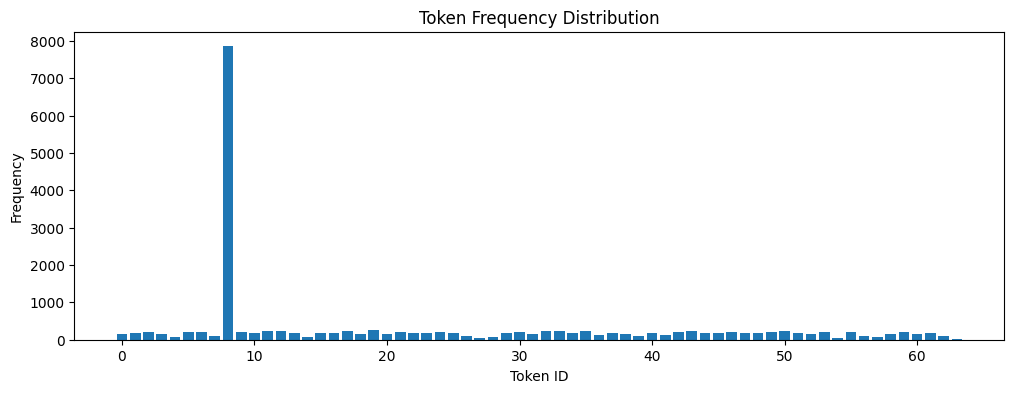

In [24]:
token_counts = np.bincount(tokens.flatten())
plt.figure(figsize=(12, 4))
plt.bar(range(len(token_counts)), token_counts)
plt.title('Token Frequency Distribution')
plt.xlabel('Token ID')
plt.ylabel('Frequency')
plt.show()


这个直方图展示了每个 token 在音频中出现的频率。从这个分布中，我们可以了解到以下几点：

- 某些 token 是否比其他 token 使用得更频繁？
在我们使用的音频示例中，token 8 是使用最频繁的。

- 是否存在从未或极少被使用的 token？
这可能表明我们可以在不损失太多信息的情况下减少 token 的数量。例如，在我们的音频中，token 27 只被使用了一次。

- 分布是否相对均匀？
这可能意味着我们对 token 词汇表的利用较好。在我们的情况中，token 8 的使用频率远高于其他 token，说明分布并不均匀。

In [25]:
# Get the indices of min and max frequency tokens 
min_token_id = np.argmin(token_counts)
max_token_id = np.argmax(token_counts)

print(f"Token ID with minimum frequency: {min_token_id} : {token_counts[min_token_id]}")
print(f"Token ID with maximum frequency: {max_token_id} : {token_counts[max_token_id]}")

Token ID with minimum frequency: 63 : 10
Token ID with maximum frequency: 8 : 7856




> 请注意，这种分布情况会因音频内容的不同而有很大差异。所以，不妨用你的音频试试看！


到目前为止，我们已经将连续的音频信号转换为一串离散的 token。这种转换之所以强大，有以下几个原因：

- **压缩（Compression）**：我们仅使用了 512 个唯一的 token 来表示复杂的音频内容。这可以带来显著的数据压缩效果。

- **离散化（Discretization）**：我们从频谱图中的连续幅度值空间转换到了 token ID 的离散空间。这使得后续的处理步骤更加简便。

- **语义表示（Semantic Representation）**：每个 token 可以看作代表了一个特定的“音频概念”。这对于音频理解和生成等任务来说是非常有力的。

- **适合机器学习（Machine Learning Friendly）**：许多机器学习模型都是为处理离散 token 设计的。现在我们的音频已经被 token 化，可以直接用于这些模型。

既然我们已经成功地对音频进行了 token 化，接下来让我们探索反向过程：如何将 token 转换回音频。这个过程主要包括两个步骤：

1. 解码token（Detokenization）：将 token 转换回梅尔频谱图；
2. 音频重建（Audio Reconstruction）：将梅尔频谱图再转换回原始的音频波形。


## Detokenization

首先，我们来实现detokenization function:


In [26]:
def vq_detokenize(tokens, kmeans):
    # Flatten the tokens
    flattened_tokens = tokens.flatten()
    
    # Use the centroids of the K-means clusters to reconstruct the features
    reconstructed_features = kmeans.cluster_centers_[flattened_tokens]
    
    # Reshape back to the original mel spectrogram shape
    reconstructed_features = reconstructed_features.reshape(tokens.shape[0], tokens.shape[1], -1)
    
    # Remove the unnecessary dimension
    return reconstructed_features.squeeze()

该函数执行以下操作：

- 将我们的2D二维标记数组展平为1D一维数组。

- 使用我们的 K-means 模型查找每个标记的质心（平均特征向量）。

- 将结果重新塑造成原始的梅尔频谱图形状。

让我们将此函数应用于我们的token：

In [27]:
reconstructed_mel = vq_detokenize(tokens, kmeans_model)

print(f"Shape of reconstructed mel spectrogram: {reconstructed_mel.shape}")

Shape of reconstructed mel spectrogram: (230, 80)


## Comparing Original and Reconstructed Spectrograms

Now, let's visually compare our original mel spectrogram with the reconstructed one.


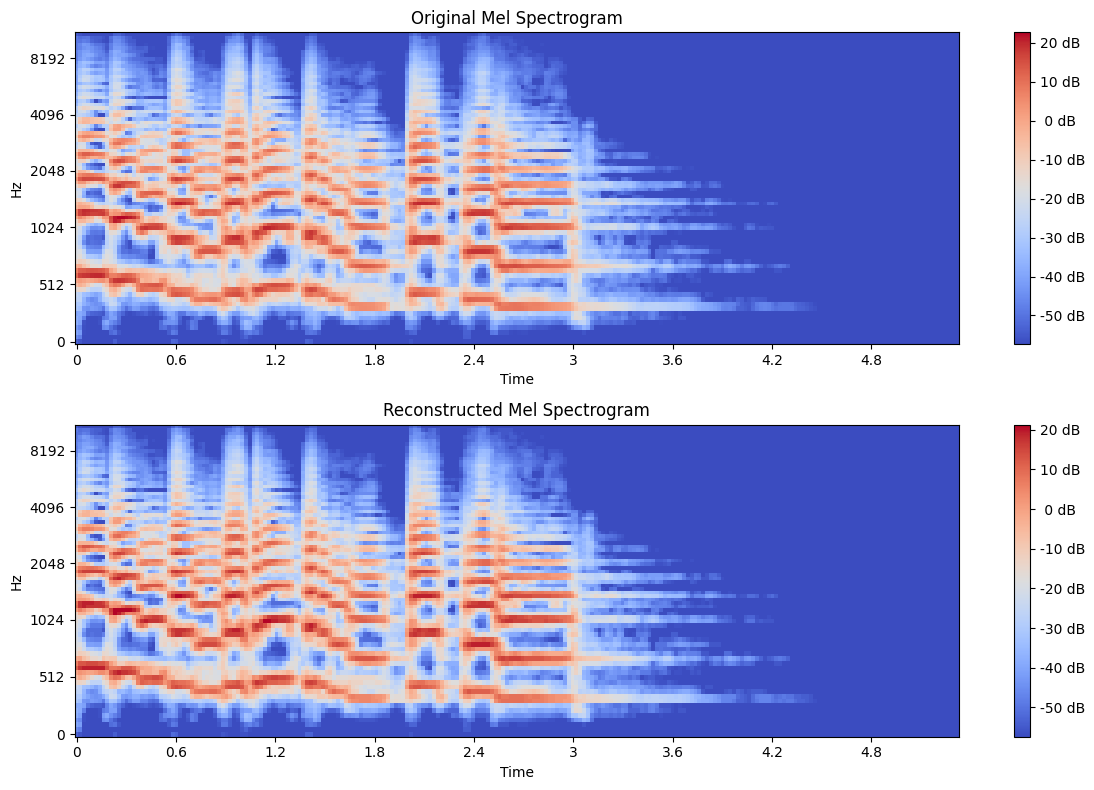

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

img1 = librosa.display.specshow(mel_features, x_axis='time', y_axis='mel', ax=ax1)
ax1.set_title('Original Mel Spectrogram')
fig.colorbar(img1, ax=ax1, format='%2.0f dB')

img2 = librosa.display.specshow(reconstructed_mel.T, x_axis='time', y_axis='mel', ax=ax2)
ax2.set_title('Reconstructed Mel Spectrogram')
fig.colorbar(img2, ax=ax2, format='%2.0f dB')

plt.tight_layout()
plt.show()

观察两个频谱图之间的差异。重建后的频谱图看起来有点“块状”，或者说细节较少。这是因为我们的分词过程将连续的频谱图量化成了一组离散的值。

## 音频重建

现在，让我们把重建的梅尔频谱图转换回音频波形。为此，我们将使用 **Griffin-Lim** 算法：

In [29]:
def mel_to_audio(mel_spec, sr, n_iter=10):
    # Convert from dB scale back to power
    mel_spec = librosa.db_to_power(mel_spec)
    
    # Use librosa's built-in Griffin-Lim implementation
    y_reconstructed = librosa.feature.inverse.mel_to_audio(mel_spec.T, sr=sr, n_iter=n_iter)
    
    return y_reconstructed

In [30]:
# Reconstruct audio
reconstructed_audio = mel_to_audio(reconstructed_mel, sampling_rate)

# Trim or pad to match original length
if len(reconstructed_audio) > len(y):
    reconstructed_audio = reconstructed_audio[:len(y)]
else:
    reconstructed_audio = np.pad(reconstructed_audio, (0, len(y) - len(reconstructed_audio)))

Griffin-Lim 算法通过估计在转换为梅尔频谱图过程中丢失的相位信息，来重建音频信号。

## 比较原始音频和重建音频

我们来听听原始音频和修复后的音频：

In [31]:
print("Original Audio:")
ipd.display(ipd.Audio(y, rate=sr))

print("Reconstructed Audio:")
ipd.display(ipd.Audio(reconstructed_audio, rate=sr))

Original Audio:


Reconstructed Audio:


您可能会注意到原始音频和重建音频之间存在一些差异。与原始音频相比，重建版本听起来可能会有些失真或扭曲。这主要是由以下几个因素造成的：

- 梅尔频谱图转换过程中的信息丢失

- 分词过程中进一步的信息丢失

- Griffin-Lim算法的相位重建不完美

## 波形比较

最后，让我们直观地比较一下原始音频和重建音频的波形：


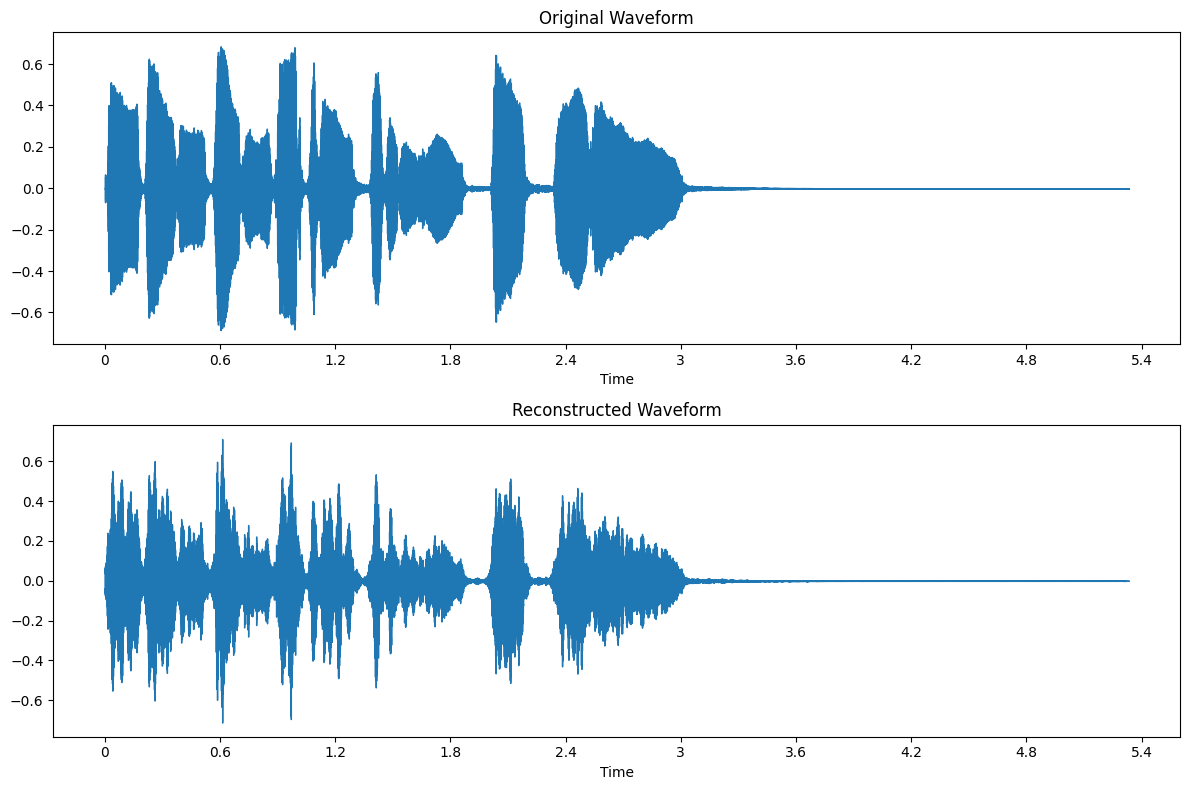

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

librosa.display.waveshow(y, sr=sampling_rate, ax=ax1)
ax1.set_title('Original Waveform')

librosa.display.waveshow(reconstructed_audio, sr=sampling_rate, ax=ax2)
ax2.set_title('Reconstructed Waveform')

plt.tight_layout()
plt.show()

请注意观察波形的整体结构得到了保留，但一些细节信息可能已经丢失，从而导致音质上出现差异。

### 小节总结

这个重建过程展示了我们分词方法的**优势与局限性**：

- **压缩效果（Compression）**：我们使用少量的 token 表示了音频，实现了显著的数据压缩。
- **信息保留（Information Preservation）**：重建后的音频保留了原始音频的大部分结构，说明我们的 token 捕捉到了音频的关键特征。
- **质量权衡（Quality Trade-off）**：音频质量有明显下降，突显了压缩率与保真度之间的权衡。

在下一节中，我们将探讨如何调整我们的分词过程，以更好地平衡这些因素，并可能进一步提升结果。

## 参数实验

我们的分词过程涉及多个可以调整的参数，以期进一步提升结果。让我们来尝试其中的一些参数：

### Token 数量

我们可以尝试使用不同数量的 token，观察其对音频质量和压缩效果的影响：

In [33]:
for n_tokens in [8, 32, 64, 128, 256]:
    tokens, kmeans_model = vq_tokenize(mel_features, n_tokens)
    reconstructed_mel = vq_detokenize(tokens, kmeans_model)
    reconstructed_audio = mel_to_audio(reconstructed_mel, sr)
    
    print(f"\nNumber of tokens: {n_tokens}")
    print(f"Compression ratio: {mel_features.size / tokens.size:.2f}x")
    
    ipd.display(ipd.Audio(reconstructed_audio, rate=sr))



Number of tokens: 8
Compression ratio: 1.00x



Number of tokens: 32
Compression ratio: 1.00x



Number of tokens: 64
Compression ratio: 1.00x



Number of tokens: 128
Compression ratio: 1.00x



Number of tokens: 256
Compression ratio: 1.00x


聆听不同 token 数量下的音频。音频质量是如何变化的？在哪个数量之后你不再感受到明显的提升？

### 梅尔频谱图参数

我们还可以调整梅尔频谱图的相关参数：

In [34]:
for n_mels in [2, 20, 40, 80, 160]:
    _, _, log_mel_spec = load_and_preprocess_audio(audio_file, sr=sampling_rate, n_mels=n_mels)
    tokens, kmeans_model = vq_tokenize(mel_features, n_tokens=64)
    reconstructed_mel = vq_detokenize(tokens, kmeans_model)
    reconstructed_audio = mel_to_audio(reconstructed_mel, sampling_rate)
    
    print(f"\nNumber of mel bands: {n_mels}")
    ipd.display(ipd.Audio(reconstructed_audio, rate=sampling_rate))


Number of mel bands: 2



Number of mel bands: 20



Number of mel bands: 40



Number of mel bands: 80



Number of mel bands: 160


改变梅尔频带的数量会如何影响音频质量？用你的音频文件进行测试，看看这些参数如何影响结果。

## 潜在优化方向

我们可以通过多种方式进一步优化分词过程：

- **高级聚类算法**：我们出于简单性考虑使用了 **K-means**，但更先进的聚类算法（如高斯混合模型）可能会带来更好的结果。
  
- **感知加权**：我们可以根据人耳的听觉感知对特征向量进行加权，从而提升重建音频的感知质量。

- **上下文感知的分词**：我们目前是独立地对每个时间-频率单元进行分词，但也可以考虑局部上下文信息，从而更好地捕捉时间结构。

- **神经网络方法**：像 **VQ-VAE**（向量量化变分自编码器）这样的深度学习模型，在音频分词任务中已经显示出良好的效果。

---

## 结论

在本教程中，我们探讨了使用向量量化（Vector Quantization, VQ）进行音频分词的过程。我们了解了如何用一组离散的 token 表示复杂的音频信号，并如何从这些 token 重建出音频。

关键收获包括：

- 音频可以被有效地表示和压缩为离散的 token。
- 压缩（token 数量少）与音质之间存在权衡。
- 整个流程包含多个步骤（梅尔频谱图转换、分词、去分词、音频重建），每一步都有其自身的挑战和优化空间。
- 尽管我们重建的音频并非完美，但它保留了原始音频的大部分结构和内容，展示了该方法的强大之处。

正如我们所看到的，音频分词为音频处理和机器学习领域打开了许多令人兴奋的可能性。虽然我们的实现相对简单，但它为理解这一领域的更先进技术打下了基础。

继续尝试这段代码，应用一些我们建议的优化方法，并探索你如何将音频分词技术应用于自己的项目中！

---

## 参考资料

- [Tom Bäckström 的《Speech Coding With Code-Excited Linear Prediction》第七章](https://www.google.de/books/edition/Speech_Coding/2vmODgAAQBAJ?hl=en) —— 这本书提供了关于向量量化及其在语音编码和压缩中的应用的全面概述。
- [Python 中的 K-Means 聚类](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) —— scikit-learn 官方文档中的 K-Means 聚类算法说明。